In [1]:
import numpy
from scipy import optimize
import scipy.linalg
from galpy.util import bovy_plot
%pylab inline

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Uncertainties on a linear fit using resampled data

The PDF for the parameters $X$ of a linear model $Y = A\,X$ with uncertainty covariance $C$ on the $Y$ measurement vector is a Gaussian with mean

\begin{equation}
X = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y]
\end{equation}

and variance

\begin{equation}
V = [A^T C^{-1} A]^{-1}.
\end{equation}

The standard way to get this PDF is simply to compute these quantities. This may be difficult, especially for the variance (the mean can be obtained by solving the system of equations $[A^T C^{-1} A] X  = A^T C^{-1} Y$, thus avoiding the inverse-matrix operation, but this does not work for the variance).

However, another method for computing the variance is to sample from the PDF in the following way. If we draw new $Y'$ data sets from the Gaussian with mean $Y$ and variance $C$ (thus, sampling the data from its uncertainty) and refit $X'$ for each $Y'$ it is easy to see the following:

(a) The distribution of $X'$ is Gaussian: $X' = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y']$, which is simply a linear transformation of a variable $Y'$ that has a Gaussian distribution $\rightarrow$ $X'$ is Gaussian distributed.

(b) The mean of $X'$ is $X$: 

\begin{align}
\langle X'\rangle & = \langle [A^T C^{-1} A]^{-1} [A^T C^{-1} Y']\rangle\\
& = [A^T C^{-1} A]^{-1} [A^T C^{-1} \langle Y' \rangle] \\
& = [A^T C^{-1} A]^{-1} [A^T C^{-1} Y]\\
& = X\,.
\end{align}

(c) The variance of $X'$ is $V$: 

\begin{align}
\langle X' X'^T\rangle &  = \langle[A^T C^{-1} A]^{-1} [A^T C^{-1} Y'] [Y'^T C^{-1} A] [A^T C^{-1} A]^{-1}\rangle \\
& = [A^T C^{-1} A]^{-1} A^T C^{-1} \langle Y' Y'^T\rangle C^{-1} A [A^T C^{-1} A]^{-1}\\
& = [A^T C^{-1} A]^{-1} A^T C^{-1} A [A^T C^{-1} A]^{-1} \\
& = [A^T C^{-1} A]^{-1} \\
& = V
\end{align}
because $\langle Y' Y'^T \rangle = C$. 

Therefore, the samples $X'$ obtained from fitting the re-sampled data $Y'$ are samples from the posterior PDF of the parameters $X$.

## Example: simple straight-line fit

Let's try this out using a simple example (using the data from exercise 1 in Hogg, Bovy, & Lang 2010). First we define the data and plot it:

In [2]:
data= numpy.array([[1,201,592,61,9,-0.84],
                   [2,244,401,25,4,0.31],
                   [3,47,583,38,11,0.64],
                   [4,287,402,15,7,-0.27],
                   [5,203,495,21,5,-0.33],
                   [6,58,173,15,9,0.67],
                   [7,210,479,27,4,-0.02],
                   [8,202,504,14,4,-0.05],
                   [9,198,510,30,11,-0.84],
                   [10,158,416,16,7,-0.69],
                   [11,165,393,14,5,0.30],
                   [12,201,442,25,5,-0.46],
                   [13,157,317,52,5,-0.03],
                   [14,131,311,16,6,0.50],
                   [15,166,400,34,6,0.73],
                   [16,160,337,31,5,-0.52],
                   [17,186,423,42,9,0.90],
                   [18,125,334,26,8,0.40],
                   [19,218,533,16,6,-0.78],
                   [20,146,344,22,5,-0.56]])

<Container object of 3 artists>

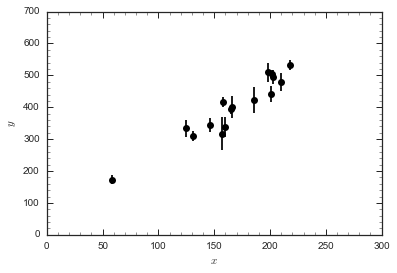

In [3]:
bovy_plot.bovy_plot(data[4:,1],data[4:,2],'ko',
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[0.,300.],
                   yrange=[0.,700.])
errorbar(data[4:,1],data[4:,2],yerr=data[4:,3],marker='None',ls='none',
         color='k')

We define a simple function that does a linear fit and perform the standard linear fit:

In [4]:
def linfit(y,x,yerr):
    # Generate Y and X arrays
    A= numpy.vander(x,N=2)
    Cinv= numpy.diag(1./yerr**2.)
    Y= numpy.dot(A.T,numpy.dot(Cinv,y))
    A= numpy.dot(A.T,numpy.dot(Cinv,A))
    return (numpy.linalg.solve(A,Y),numpy.linalg.inv(A))

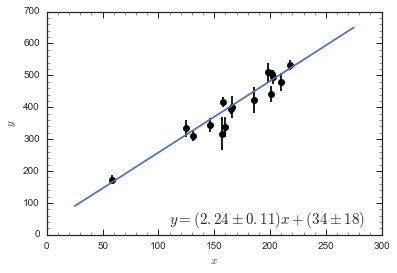

In [5]:
X, Xcov= linfit(data[4:,2],data[4:,1],data[4:,3])
xxs= numpy.linspace(25.,275.,1001)
bovy_plot.bovy_plot(data[4:,1],data[4:,2],'ko',
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[0.,300.],
                   yrange=[0.,700.])
errorbar(data[4:,1],data[4:,2],yerr=data[4:,3],marker='None',ls='none',
        color='k')
plot(xxs,numpy.dot(numpy.vander(xxs,N=2),X))
bovy_plot.bovy_text(r'$y = (%.2f\pm%.2f) x + (%.0f\pm%.0f)$' % (X[0],numpy.sqrt(Xcov[0,0]),X[1],numpy.sqrt(Xcov[1,1])),
                    bottom_right=True,size=15.)

Now we compute the $X'$ samples and use the mean and variance to get the best-fit and the uncertainties:

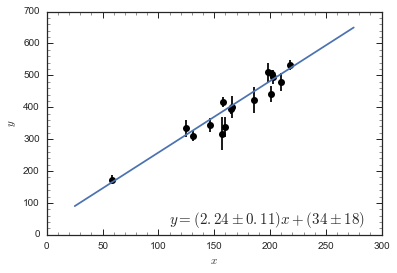

In [6]:
Xs= []
nsamp= 10000
for ii in range(nsamp):
    X, Xcov= linfit(data[4:,2]+numpy.random.normal(size=len(data[4:,2]))*data[4:,3],
                    data[4:,1],data[4:,3])
    Xs.append(X)
Xs= numpy.array(Xs)
bovy_plot.bovy_plot(data[4:,1],data[4:,2],'ko',
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[0.,300.],
                   yrange=[0.,700.])
errorbar(data[4:,1],data[4:,2],yerr=data[4:,3],marker='None',ls='none',
        color='k')
plot(xxs,numpy.dot(numpy.vander(xxs,N=2),numpy.mean(Xs,axis=0)))
bovy_plot.bovy_text(r'$y = (%.2f\pm%.2f) x + (%.0f\pm%.0f)$' % (numpy.mean(Xs,axis=0)[0],
                                                                numpy.std(Xs,axis=0)[0],
                                                                numpy.mean(Xs,axis=0)[1],
                                                                numpy.std(Xs,axis=0)[1]),
                    bottom_right=True,size=15.)

The two agree! Let's look at the 2D PDFs (density+black contours: data re-sampling, red contours: analytic Gaussian PDF):

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1210: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):



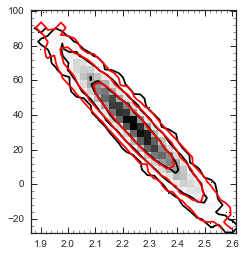

In [7]:
bovy_plot.scatterplot(Xs[:,0],Xs[:,1],'k,',bins=31)
# Sample from Gaussian
X, Xcov= linfit(data[4:,2],data[4:,1],data[4:,3])
L= scipy.linalg.cho_factor(Xcov,lower=True)[0]
L[0,1]= 0.
ii= 0
Xs= []
while ii < nsamp:
    tX= numpy.dot(L,numpy.random.normal(size=2))+X
    Xs.append(tX)
    ii+= 1
Xs= numpy.array(Xs)
bovy_plot.scatterplot(Xs[:,0],Xs[:,1],'k,',justcontours=True,overplot=True,cntrcolors='r',bins=31)

These are pretty much the same.

## Example: non-negative straight-line fit

Does this still work for a non-negative straight-line fit? Fitting with non-negative least squares gives:

In [8]:
def nnls(y,x,yerr):
    # Generate Y and X arrays
    A= numpy.vander(x,N=2)
    Cinv= numpy.diag(1./yerr**2.)
    Y= numpy.dot(A.T,numpy.dot(Cinv,y))
    A= numpy.dot(A.T,numpy.dot(Cinv,A))
    return (optimize.nnls(A,Y)[0],numpy.linalg.inv(A))

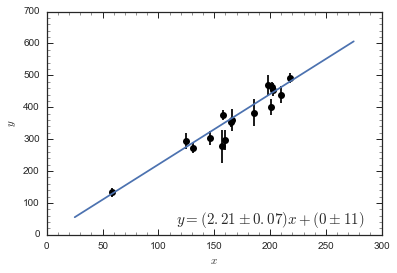

In [9]:
yoffset= -40.
X, Xcov= nnls(data[4:,2]+yoffset,data[4:,1],data[4:,3])
xxs= numpy.linspace(25.,275.,1001)
bovy_plot.bovy_plot(data[4:,1],data[4:,2]+yoffset,'ko',
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[0.,300.],
                   yrange=[0.,700.])
errorbar(data[4:,1],data[4:,2]+yoffset,yerr=data[4:,3],marker='None',ls='none',
        color='k')
plot(xxs,numpy.dot(numpy.vander(xxs,N=2),X))
Xs= []
nsamp= 100000
L= scipy.linalg.cho_factor(Xcov,lower=True)[0]
L[0,1]= 0.
ii= 0
while ii < nsamp:
    tX= numpy.dot(L,numpy.random.normal(size=2))+X
    if numpy.all(tX > 0.):
        Xs.append(tX)
        ii+= 1
Xs= numpy.array(Xs)
bovy_plot.bovy_text(r'$y = (%.2f\pm%.2f) x + (%.0f\pm%.0f)$' % (X[0],
                                                                numpy.std(Xs,axis=0)[0],
                                                                X[1],
                                                                numpy.std(Xs,axis=0)[1]),
                    bottom_right=True,size=15.)

where the uncertainty comes straight from the (regular) covariance (so isn't quite correct). A sampling by re-sampling the data gives:

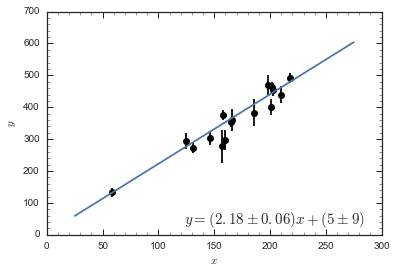

In [10]:
sXs= []
nsamp= 100000
for ii in range(nsamp):
    X, Xcov= nnls(data[4:,2]+numpy.random.normal(size=len(data[4:,2]))*data[4:,3]+yoffset,
                    data[4:,1],data[4:,3])
    sXs.append(X)
sXs= numpy.array(sXs)
bovy_plot.bovy_plot(data[4:,1],data[4:,2]+yoffset,'ko',
                   xlabel=r'$x$',ylabel=r'$y$',
                   xrange=[0.,300.],
                   yrange=[0.,700.])
errorbar(data[4:,1],data[4:,2]+yoffset,yerr=data[4:,3],marker='None',ls='none',
        color='k')
plot(xxs,numpy.dot(numpy.vander(xxs,N=2),numpy.mean(sXs,axis=0)))
bovy_plot.bovy_text(r'$y = (%.2f\pm%.2f) x + (%.0f\pm%.0f)$' % (numpy.mean(sXs,axis=0)[0],
                                                                numpy.std(sXs,axis=0)[0],
                                                                numpy.mean(sXs,axis=0)[1],
                                                                numpy.std(sXs,axis=0)[1]),
                    bottom_right=True,size=15.)

Samples drawn from the data re-sampling (black) and from drawing points from the positive quadrant of the uncertainty Gaussian (red) gives similar distribution, except that many of the re-sampled samples are exactly at zero. Above zero the distributions are very similar:

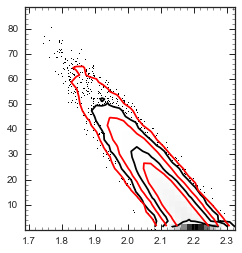

In [11]:
bovy_plot.scatterplot(sXs[:,0],sXs[:,1],'k,',bins=31)
bovy_plot.scatterplot(Xs[:,0],Xs[:,1],'k,',justcontours=True,overplot=True,cntrcolors='r',bins=31)

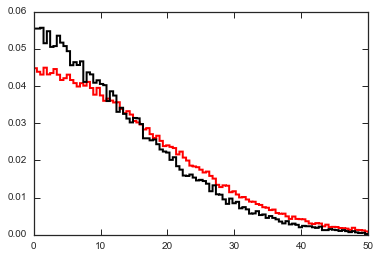

In [12]:
_= hist(Xs[:,1],bins=101,range=[0.001,50.],histtype='step',lw=2.,normed=True,color='r')
_= hist(sXs[:,1],bins=101,range=[0.001,50.],histtype='step',lw=2.,normed=True,color='k')